In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.special import expit
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,make_scorer,f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
ss=StandardScaler()

In [3]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
import random

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
le=LabelEncoder()

In [6]:
class TrainAuto:
    def __init__(self, dataset):
        
        #preprocessing step- setting up scaling for datasets which need them
        
        self.data=dataset
        self.scale=False
        
    def Traindata(self):
        column_titles=['Target']
        dft=pd.read_csv(self.data)
        
        #preprocessing step- changing the labels and deleting unwanted columns
        
        if ('Label' in dft.columns):
            dft['Label']=le.fit_transform(dft['Label'])
            dft.loc[dft['Label'] == 1, "Target"] = -1
            dft.loc[dft['Label'] == 0, "Target"] = 1
            dft.drop(['Label'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
        elif ('Class' in dft.columns):
            self.scale=False
            dft.loc[dft['Class'] == 1, "Target"] = -1
            dft.loc[dft['Class'] == 0, "Target"] = 1
            dft.drop(['Class','Time'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
        else:
            self.scale=True
            dft.dropna(axis=0,inplace=True)
            dft.reset_index(drop=True)
            let=LabelEncoder()
            dft['type']=let.fit_transform(dft['type'])
            dft.loc[dft['quality'].isin([3,4,5,6,7]),"Target"] = 1
            dft.loc[dft['quality'].isin([8,9]),"Target"] = -1
            dft.drop(['quality'],inplace=True,axis=1)
            column_titles.extend([x for x in dft.columns if x!='Target'])
            dft=dft.reindex(columns=column_titles)
            
        #using train-test split to create an appropriate split
        
        final_inliers = dft[dft['Target']==1]
        final_inliers_train, final_inliers_test = train_test_split(final_inliers, test_size=0.20, random_state=42)
        final_outlier = dft[dft['Target']==-1]
        len_outliers=final_outlier[:25]
        len_inliers=final_inliers_test[:18]
        
        #setting up validation set for hyper-parameter tuning
        
        if self.scale==False:
            final_val_set=pd.concat([len_outliers,len_inliers])
        else:
            final_val_set=pd.concat([len_outliers,len_inliers])
            final_val_set=pd.DataFrame(ss.fit_transform(final_val_set))
        if self.scale==False:
            final_train_scale=final_inliers_train.iloc[:,1:]
        else:
            final_train_scale=final_inliers_train.iloc[:,1:]
            final_train_scale=pd.DataFrame(ss.fit_transform(final_train_scale))
        final_test_scale=final_inliers_test.iloc[18:,1:]
        finoutlier_scale=final_outlier.iloc[25:,1:]
        yfin_test_in = final_inliers_test['Target'].iloc[18:]
        yfin_test_out = final_outlier['Target'].iloc[25:]
        y_fin_testval = pd.concat([yfin_test_in, yfin_test_out])
        y_fin_testval = np.array(y_fin_testval)
        if self.scale==False:
            df_fin_testval = pd.concat([final_test_scale,finoutlier_scale])
        else:
            df_fin_testval = pd.concat([final_test_scale,finoutlier_scale])
            df_fin_testval = pd.DataFrame(ss.fit_transform(df_fin_testval))  
        
        #returning the train, test and validation sets
        
        return final_train_scale,df_fin_testval,final_val_set,y_fin_testval
    
    def TuneData(self,val_set,train_set,df_test,y_test):
        
        #setting up parameters for OneClassSVM
        
        ocsvm_params = {'gamma' : ['scale','auto'], 'nu': [0.001,0.01,0.2,1], 'kernel':['poly','rbf','sigmoid','linear'],'degree':[3,5,8,10,12]}
        clf_ocsvm = GridSearchCV(OneClassSVM(), ocsvm_params, cv = 30, scoring='f1_micro')
        clf_ocsvm.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_fin=OneClassSVM(gamma=clf_ocsvm.best_params_['gamma'], nu=clf_ocsvm.best_params_['nu'],kernel=clf_ocsvm.best_params_['kernel'],degree=clf_ocsvm.best_params_['degree'])
        
        #Training model on the best parameters obtained
        model_fin.fit(train_set)
        
        #Setting up parameters for Isolation Forest
        isofor_params={'contamination' : [0.0017304750013189597,0.19055313859,0.19590178], 'n_estimators': [300], 'max_features':[5,6]}
        clf_isofor = GridSearchCV(IsolationForest(), isofor_params, cv = 30, scoring='f1_micro')
        clf_isofor.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_iso=IsolationForest(contamination=clf_isofor.best_params_['contamination'], n_estimators=clf_isofor.best_params_['n_estimators'],max_features=clf_isofor.best_params_['max_features'])
        
        #training model on the best parameters obtained
        model_iso.fit(train_set)
        
        #parameter dictionary for Elliptic Envelope
        
        ee_params={'contamination' : [0.2, 0.3, 0.19055313859,0.0017304750013189597], 'assume_centered': [True,False], 'support_fraction':[None,0.6,0.9]}
        clf_ee = GridSearchCV(EllipticEnvelope(), ee_params, cv = 30, scoring='f1_micro')
        clf_ee.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_ee=EllipticEnvelope(contamination=clf_ee.best_params_['contamination'], assume_centered=clf_ee.best_params_['assume_centered'],support_fraction=clf_ee.best_params_['support_fraction'])
        
        #training the elliptic envelope model on the best parameters
        
        model_ee.fit(train_set)
        
        #parameter dictionary for Local Outlier Factor
        lof_params={'contamination' : ['auto',0.0017304750013189597,0.3], 'n_neighbors': [14,30]}  
        clf_lof = GridSearchCV(LocalOutlierFactor(), lof_params, cv = 30, scoring='f1_micro')
        clf_lof.fit(val_set.iloc[:,1:],val_set.iloc[:,0])
        model_lof=LocalOutlierFactor(contamination=clf_lof.best_params_['contamination'],n_neighbors=clf_lof.best_params_['n_neighbors'],novelty=True)
        
        #training the Local Outlier Factor model on the best parameters obtained
        model_lof.fit(train_set)
        
        #returning the trained models in a list
        
        return [model_fin,model_iso,model_ee,model_lof]
    
    
    #Exp3 algorithm
    def exp3_base(self,X_test,y_test,model_list):
        
        #setting up learning rate
        lr = -(np.sqrt(np.log(2) / (2000 * 2)))
        
        #Setting up psuedo loss
        losses = [[0,0,0,0]]
        todf=[]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)
        
        #to collect the predicted values
        pred=[]
        
        #to collect the actual values
        act=[]
        for t in range(1,100000):
            
            #list to maintain probability distribution for the current time-step
            cur_distribution = []
            
            #list to maintain the loss vector of the current time-step
            new_loss=[]
            
            #context vector for the current time-step
            
            dfrow=dftest.sample()
            
            #sum of exponential values of losses in the previous time-step for probabilty distribution
            
            sum_losses = np.sum([np.exp(s * lr) for s in losses[t-1]])
            
            #calulating the probability distribution for the current time-step
            
            for i in range(4):
                cur_distribution.append(np.exp(lr * losses[t-1][i]) / sum_losses)
            arm_probs = [(arm, cur_distribution[arm]) for arm in range(4)]
            
            #calling the choose_arm method to select the expert for the current time-step
            
            chosen_arm = self.choose_arm(arm_probs)
            
            #using get loss method to check the prediction for the context vector
            
            cur_loss,y_pred = self.get_loss(model_list,chosen_arm,dfrow.iloc[:,:-1],dfrow.iloc[:,-1].values[0])
            
            pred.append(y_pred)
            act.append(dfrow.iloc[:,-1].values[0])
            
            #creating the loss vector for the current time-step
            
            loss_vec= [0 if i!=chosen_arm else cur_loss for i in range(4)]
            
            #calculating the psuedo loss for the current time-step
            for i in range(4):
                new_loss.append(losses[t-1][i]+(loss_vec[i]/cur_distribution[i]))
            losses.append(new_loss)
            todf.append(cur_loss)
        
        #calulating the f1-score
        print("The f1-score is :",f1_score(pred,act))
        
        #return the list of losses to plot regret
        return todf
    
    #helper function for Exp3 to choose the expert for the given time-step
    def choose_arm(self,prob_value_list):
        arms = [tup[0] for tup in prob_value_list]
        probs = [float(tup[1]) for tup in prob_value_list]
        return random.choices(arms,weights=probs)[0]
    
    #helper function to check the loss against the actual y-label
    def get_loss(self,model_list,chosen_arm,X_test,y_test):
        y_pred = model_list[chosen_arm].predict(X_test)
        if y_pred==y_test:
            return 0,y_pred
        else:
            return 1,y_pred 
        
    #Exp4 Algorithm    
    def exp4_base(self,trial,X_test,y_test,model_list):
        
        #learning rate
        lr = -(np.sqrt(np.log(2) / (trial* 2)))
        
        #intial value for q vector that maintains the strength of experts
        q=[[1/4,1/4,1/4,1/4]]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)  
        todf=[]
        pred=[]
        act=[]
        
        for t in range(100000):
            psuedo_loss=[]
            newq=[]
            
            #getting the context vector for the current round
            dfrow=dftest.sample()
            
            #calling helper function to get expert advice
            
            exp_pred=self.exppred(model_list,dfrow.iloc[:,:-1])
            
            #Calculating the probability distribution for the time-step
            cur_distribution = np.dot(q[t],exp_pred)
            
            #calling function to find the loss against the true label value
            
            loss_vec,lpred= self.cur_loss(cur_distribution,dfrow.iloc[:,-1].values[0])
            
            #appending the loss values to a list to plot regret
            todf.append(loss_vec[0])
            act.append(dfrow.iloc[:,-1].values[0])
            pred.append(lpred)
            
            #Calculating the psuedo-loss
            for i in range(2):
                psuedo_loss.append(loss_vec[i]/cur_distribution[i])
            psuedo_loss=np.array(psuedo_loss)
            
            #Calculating the loss value with respect to each expert
            loss_cap=np.dot(exp_pred,psuedo_loss)
            
            sum_losses=np.sum([np.exp(s * lr) for s in loss_cap])
            
            #calculating the strength of experts for the next round
            for i in range(4):
                newq.append((np.exp(lr * loss_cap[i])*q[t][i])/(sum_losses*q[t][i]))
            q.append(newq)
        print("The f1-score is :",f1_score(act,pred))
        return todf

    #helper function to generate expert advice
    def exppred(self,model_list,X_test):
        newl=[]
        for x in range(4):
            sig=mlist[x].decision_function(X_test)
            newl.append([1-expit(sig)[0],expit(sig)[0]])
        newl=np.array(newl)
        return newl

    #helper function to check the loss
    def cur_loss(self,distb,y_test):
        label=[-1,1]
        prob=[distb[0],distb[1]]
        pred=random.choices(label,weights=prob)[0]
        if y_test==pred:
            return [0,1],pred
        else:
            return [1,0],pred
        
    #Batched Exp4    
    def exp4_batched(self,epoch,trial,X_test,y_test,model_list):
        lr = -(np.sqrt(np.log(2) / (trial* 2)))
        q=[[1/4,1/4,1/4,1/4]]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)  
        todf=[]
        epochsuml=[]
        j=1
        while j<=(1000/epoch):
            lo=0
            for t in range(1000):
                psuedo_loss=[]
                newq=[]
                dfrow=dftest.sample()
                exp_pred=self.exppred(model_list,dfrow.iloc[:,:-1])
                cur_distribution = np.dot(q[t],exp_pred)
                loss_vec,nl,_= self.cur_loss(cur_distribution,dfrow.iloc[:,-1].values[0])
                lo=lo+nl
                for i in range(2):
                    psuedo_loss.append(loss_vec[i]/cur_distribution[i])
                psuedo_loss=np.array(psuedo_loss)
                loss_cap=np.dot(exp_pred,psuedo_loss)
                sum_losses=np.sum([np.exp(s * lr) for s in loss_cap])
                for i in range(4):
                    newq.append((np.exp(lr * loss_cap[i])*q[t][i])/(sum_losses*q[t][i]))
                q.append(newq)
            print("the loss is :",lo)
            epochsuml.append(lo)
            j=j+1
        epochsuml=[x/1000 for x in epochsuml]
        ro=int(1000/epoch)
        self.plot_regret_chart(epochsuml,ro)
    
    #helper function to plot regret
    def plot_regret_chart(self,loss,rounds,label):
        regret_loss=[]
        cumal_loss=np.cumsum(loss)
        for i in range(1,rounds):
            regret_loss.append(cumal_loss[i-1]/i)
        plt.plot(range(1,rounds),regret_loss,label=label)
        
    #Random Action Algorithm that picks experts randomly in every time-step    
    def random_action(self,X_test,y_test,model_list):
        lossl=[]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)  
        for t in range(100000):
            dfrow=dftest.sample()
            selectarm=random.choices(range(0,4))[0]
            ypred=model_list[selectarm].predict(dfrow.iloc[:,:-1])
            if ypred==dfrow.iloc[:,-1].values[0]:
                lossl.append(0)
            else:
                lossl.append(1)
        return lossl
        
    #Epsilon Greedy Algorithm
    def epsilon_greedy(self,epsilon,X_test,y_test,model_list):
        lossl=[]
        y_test=pd.DataFrame(y_test)
        y_test.set_index(X_test.index,inplace=True)
        dftest=pd.concat([df_test, y_test], axis=1)
        qvalues=np.zeros(4)
        lossval=np.zeros(4)
        armpull=np.zeros(4)
        lossl=[]
        for t in range(100000):
            dfrow=dftest.sample()
            if np.random.random()<epsilon:
                pred=random.choices(range(0,4))[0]
            else:
                pred=np.argmin(qvalues)
            ypred=model_list[pred].predict(dfrow.iloc[:,:-1])
            if ypred==dfrow.iloc[:,-1].values[0]:
                curr_loss=0
            else:
                curr_loss=1
            lossval[pred]=lossval[pred]+curr_loss
            armpull[pred]=armpull[pred]+1
            qvalues[pred]=lossval[pred]/lossval[pred]
            lossl.append(curr_loss)
        return lossl
            
        

In [7]:
#checking for Credit Card Dataset
sr=TrainAuto('creditcard.csv')

In [8]:
df_train,df_test,df_val,y_test=sr.Traindata()

In [9]:
mlist=sr.TuneData(df_val,df_train,df_test,y_test)

In [11]:
gh=sr.exp3_base(df_test,y_test,mlist)
jk=sr.random_action(df_test,y_test,mlist)

The f1-score is : 0.9942532206119163


In [10]:
fg=sr.exp4_base(200,df_test,y_test,mlist)

The f1-score is : 0.8546193231773541


In [12]:
#checking for wine quality dataset
wq=TrainAuto('winequalityN.csv')
df_train,df_test,df_val,y_test=wq.Traindata()
mlist=wq.TuneData(df_val,df_train,df_test,y_test)
wq_exp3=wq.exp3_base(df_test,y_test,mlist)
wq_exp4=wq.exp4_base(2000,df_test,y_test,mlist)
wq_random=wq.random_action(df_test,y_test,mlist)

The f1-score is : 0.9330501510187091
The f1-score is : 0.7108546875738926


In [29]:
#Checking for Cardioctography dataset
cg=TrainAuto('cardio.csv')
df_train,df_test,df_val,y_test=cg.Traindata()
mlist=cg.TuneData(df_val,df_train,df_test,y_test)
cg_exp3=cg.exp3_base(df_test,y_test,mlist)
cg_exp4=cg.exp4_base(2000,df_test,y_test,mlist)
cg_random=cg.random_action(df_test,y_test,mlist)

The f1-score is : 0.8587252234745433
The f1-score is : 0.7118089770503977


In [ ]:
#checking for Mammography dataset
mg=TrainAuto('mammography.csv')
df_train,df_test,df_val,y_test=mg.Traindata()
mlist=mg.TuneData(df_val,df_train,df_test,y_test)
mg_exp3=mg.exp3_base(df_test,y_test,mlist)
mg_exp4=mg.exp4_base(2000,df_test,y_test,mlist)
mg_random=mg.random_action(df_test,y_test,mlist)

In [30]:
#Checking for vertebral disease dataset
vd=TrainAuto('Vertebral.csv')
df_train,df_test,df_val,y_test=vd.Traindata()
mlist=vd.TuneData(df_val,df_train,df_test,y_test)
vd_exp3=vd.exp3_base(df_test,y_test,mlist)
vd_exp4=vd.exp4_base(2000,df_test,y_test,mlist)
vd_random=vd.random_action(df_test,y_test,mlist)

The f1-score is : 0.9041185980873043
The f1-score is : 0.7619898641377016


Regret Chart for Credit Card Dataset using Exp3


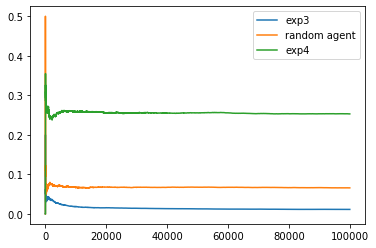

In [13]:
#Regret Chart for Credit card
print('Regret Chart for Credit Card Dataset using Exp3')
sr.plot_regret_chart(gh,100000,label='exp3')
sr.plot_regret_chart(jk,100000,label='random agent')
sr.plot_regret_chart(fg,100000,label='exp4')
plt.legend()

Regret Chart for Credit Card Dataset using Random Agent


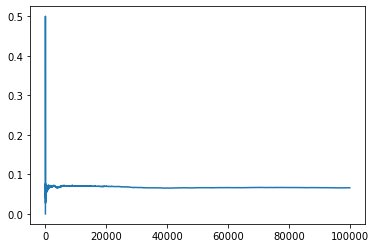

In [24]:
print('Regret Chart for Credit Card Dataset using Random Agent')
sr.plot_regret_chart(jk,100000)

Regret Chart for Credit Card Dataset using Exp4


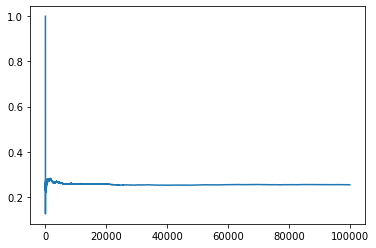

In [25]:
print('Regret Chart for Credit Card Dataset using Exp4')
sr.plot_regret_chart(fg,100000)

Regret Chart for Wine Quality Dataset using Exp3


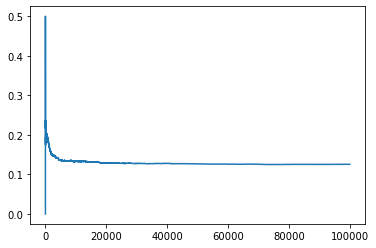

In [26]:
print('Regret Chart for Wine Quality Dataset using Exp3')
wq.plot_regret_chart(wq_exp3,100000)

Regret Chart for Wine Quality Dataset using Random Agent


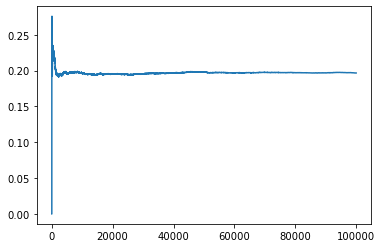

In [27]:
print('Regret Chart for Wine Quality Dataset using Random Agent')
wq.plot_regret_chart(wq_random,100000)

Regret Chart for Wine Quality Dataset using Exp4


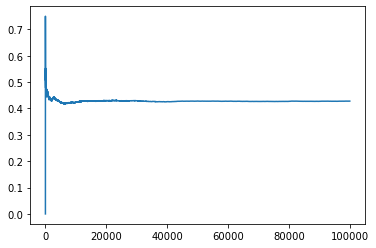

In [28]:
print('Regret Chart for Wine Quality Dataset using Exp4')
wq.plot_regret_chart(wq_exp4,100000)

Regret Chart for Cardioctology Dataset using Exp3


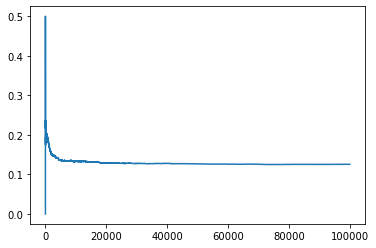

In [31]:
print('Regret Chart for Cardioctology Dataset using Exp3')
wq.plot_regret_chart(wq_exp3,100000)